In [1]:
import sys

# For hiding passwords
import getpass

# For working with data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For building models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import mlflow
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Ignoring user warning
import warnings
# warnings.filterwarnings(action='ignore', category=UserWarning)
# warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# For registering models
from sasctl import publish_model, pzmm, Session
from pathlib import Path
import os
import requests
import json

In [2]:
# Import data
data = pd.read_csv("./data/Detailed_Statistics_Arrivals.csv")

In [3]:
data.head()

,Carrier,Date,FlightNumber,TailNumber,OriginAirport,ScheduledArrival,ActualArrival,ScheduledElapsedTime,ActualElapsedTime,ArrivalDelay,WheelsOnTime,TaxiInTime,DelayCarrier,DelayWeather,DelayNAS,DelaySecurity,DelayLateAircraftArrival
0,AA,09/01/2022,317,N904AA,DFW,22:27,00:18,167,161,111,00:10,8,0,81,0,0,30
1,AA,09/01/2022,425,N934AA,PHX,21:38,21:50,71,63,12,21:43,7,0,0,0,0,0
2,AA,09/01/2022,739,N997AA,LAX,18:49,18:53,74,79,4,18:49,4,0,0,0,0,0
3,AA,09/01/2022,750,N537UW,CLT,16:09,15:54,276,268,-15,15:39,15,0,0,0,0,0
4,AA,09/01/2022,862,N323RM,PHX,18:01,17:54,70,70,-7,17:48,6,0,0,0,0,0


In [4]:
data.dtypes

Carrier                     object
Date                        object
FlightNumber                 int64
TailNumber                  object
OriginAirport               object
ScheduledArrival            object
ActualArrival               object
ScheduledElapsedTime         int64
ActualElapsedTime            int64
ArrivalDelay                 int64
WheelsOnTime                object
TaxiInTime                   int64
DelayCarrier                 int64
DelayWeather                 int64
DelayNAS                     int64
DelaySecurity                int64
DelayLateAircraftArrival     int64
dtype: object

In [5]:
# Remap Airline Names
dict = {"AA" : 'American Airlines', 
        "AS" : 'Alaska Airlines', 
        "B6": 'JetBlue Airways', 
        "DL" : 'Delta Airlines', 
        "F9": 'Frontier Airlines',
        "NK": 'Spirit Airlines',
        "WN": 'Southwest Airlines'}

data = data.replace({"Carrier": dict})

In [6]:
# Clean up date columns
data['DayofMonth'] = pd.to_datetime(data['Date'], format='%m/%d/%Y').dt.day
data['ScheduledArrivalDatetime'] = pd.to_datetime((data['Date']) + data['ScheduledArrival'], format='%m/%d/%Y%H:%M')

In [7]:
# Create Delay
data['Delay'] = np.where(data['ArrivalDelay'] > 15, 1, 0)

In [8]:
# Create Departure Time
data['DepartureDatetime'] = data['ScheduledArrivalDatetime'] - pd.to_timedelta(data['ScheduledElapsedTime'], unit='minute')

# Extract Arrival and Departure Hour
data['ArrivalHour'] = pd.to_datetime(data['ScheduledArrivalDatetime']).dt.hour
data['DepartureHour'] = pd.to_datetime(data['DepartureDatetime']).dt.hour

In [9]:
# Clean up time columns
data = data.replace({'24:00': '23:59'})
data['ScheduledArrival'] = pd.to_datetime(data['ScheduledArrival'], format='%H:%M').dt.time
data['ActualArrival'] = pd.to_datetime(data['ActualArrival'], format='%H:%M').dt.time
data['DepartureTime'] = pd.to_datetime(data['DepartureDatetime'], format='%H:%M').dt.time

In [10]:
data.head()

,Carrier,Date,FlightNumber,TailNumber,OriginAirport,ScheduledArrival,ActualArrival,ScheduledElapsedTime,ActualElapsedTime,ArrivalDelay,...,DelayNAS,DelaySecurity,DelayLateAircraftArrival,DayofMonth,ScheduledArrivalDatetime,Delay,DepartureDatetime,ArrivalHour,DepartureHour,DepartureTime
0,American Airlines,09/01/2022,317,N904AA,DFW,22:27:00,00:18:00,167,161,111,...,0,0,30,1,2022-09-01 22:27:00,1,2022-09-01 19:40:00,22,19,19:40:00
1,American Airlines,09/01/2022,425,N934AA,PHX,21:38:00,21:50:00,71,63,12,...,0,0,0,1,2022-09-01 21:38:00,0,2022-09-01 20:27:00,21,20,20:27:00
2,American Airlines,09/01/2022,739,N997AA,LAX,18:49:00,18:53:00,74,79,4,...,0,0,0,1,2022-09-01 18:49:00,0,2022-09-01 17:35:00,18,17,17:35:00
3,American Airlines,09/01/2022,750,N537UW,CLT,16:09:00,15:54:00,276,268,-15,...,0,0,0,1,2022-09-01 16:09:00,0,2022-09-01 11:33:00,16,11,11:33:00
4,American Airlines,09/01/2022,862,N323RM,PHX,18:01:00,17:54:00,70,70,-7,...,0,0,0,1,2022-09-01 18:01:00,0,2022-09-01 16:51:00,18,16,16:51:00


In [11]:
data.isnull().sum()

Carrier                      0
Date                         0
FlightNumber                 0
TailNumber                  35
OriginAirport                0
ScheduledArrival             0
ActualArrival                0
ScheduledElapsedTime         0
ActualElapsedTime            0
ArrivalDelay                 0
WheelsOnTime                 0
TaxiInTime                   0
DelayCarrier                 0
DelayWeather                 0
DelayNAS                     0
DelaySecurity                0
DelayLateAircraftArrival     0
DayofMonth                   0
ScheduledArrivalDatetime     0
Delay                        0
DepartureDatetime            0
ArrivalHour                  0
DepartureHour                0
DepartureTime                0
dtype: int64

<Axes: xlabel='OriginAirport'>

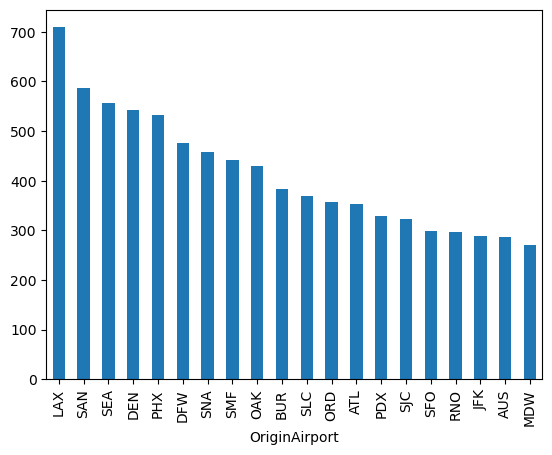

In [12]:
data['OriginAirport'].value_counts()[:20].plot(kind='bar', xlabel='OriginAirport')

In [13]:
print("There are", data['OriginAirport'].nunique(), "unique origin airports in this dataset.")

print("There were", data[data['OriginAirport'] == 'RDU'].shape[0], "direct flights from RDU.")

There are 83 unique origin airports in this dataset.
There were 63 direct flights from RDU.


<Axes: xlabel='Carrier'>

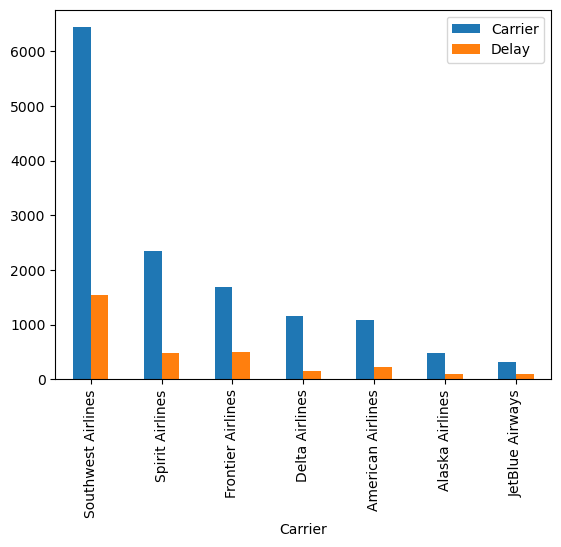

In [14]:
pd.concat([data['Carrier'].value_counts(), data.groupby('Carrier')['Delay'].sum()], axis=1).plot.bar(xlabel='Carrier')

In [15]:
print(round(data['Delay'].sum() / len(data)* 100, 2), "% of flights were delayed")

22.94 % of flights were delayed


In [16]:
# Output data to file
data.to_csv('./data/Detailed_Statistics_Arrivals_DM.csv')

In [16]:
# Specify inputs and target
inputs = ['Carrier', 'DayofMonth', 'OriginAirport', 'ScheduledElapsedTime', 'ArrivalHour', 'DepartureHour']
target = 'Delay'

# Create X and y datasets
X = data[inputs]
y = data[target]

In [17]:
# Separate training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# Create one-hot-encoding step
cat_cols = ['Carrier', 'OriginAirport']
cat_onehot_step = ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_pipe = Pipeline([cat_onehot_step])
ct = ColumnTransformer(transformers=[('cat', cat_pipe, cat_cols)])

In [19]:
# Scikit-learn
# Create pipeline with one-hot-encoding and logistic regression
logreg_pipe = Pipeline([('transform', ct), ('logreg', LogisticRegression(solver='newton-cg'))])
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Carrier',
                                                   'OriginAirport'])])),
                ('logreg', LogisticRegression(solver='newton-cg'))])

In [20]:
train = logreg_pipe.score(X_train, y_train)
test = logreg_pipe.score(X_test, y_test)

print("Training accuracy: ", train)
print("Test accuracy: ", test)

Training accuracy:  0.7717758985200845
Test accuracy:  0.7694204685573366


In [21]:
# XGBoost
# Create pipeline with one-hot-encoding and xgboost
xgb_pipe = Pipeline([('transform', ct), ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Carrier',
                                                   'OriginAirport'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=Non...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [22]:
train = xgb_pipe.score(X_train, y_train)
test = xgb_pipe.score(X_test, y_test)

print("Training accuracy: ", train)
print("Test accuracy :", test)

Training accuracy:  0.7719873150105708
Test accuracy : 0.7684340320591861


In [23]:
# MLflow

forest_pipe = Pipeline([('transform', ct), ('forest', RandomForestClassifier(n_estimators=50, max_depth=7))])
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Carrier',
                                                   'OriginAirport'])])),
                ('forest',
                 RandomForestClassifier(max_depth=7, n_estimators=50))])

In [24]:
signature = infer_signature(X_train, forest_pipe.predict(X_train))

In [25]:
train = forest_pipe.score(X_train, y_train)
test = forest_pipe.score(X_test, y_test)

print("Training accuracy: ", train)
mlflow.log_metric("Training accuracy", train)
print("Test accuracy: ", train)
mlflow.log_metric("Test accuracy", train)

Training accuracy:  0.7706131078224101
Test accuracy:  0.7706131078224101


In [26]:
mlflow.sklearn.log_model(forest_pipe, "model", signature=signature)
print("Model save in run %s" % mlflow.active_run().info.run_uuid)

Model save in run 32624031b0f2415292f8c19f3053f83a


In [27]:
# Keras
X_train_keras = X_train[['DayofMonth', 'ScheduledElapsedTime', 'ArrivalHour', 'DepartureHour']]
X_test_keras = X_test[['DayofMonth', 'ScheduledElapsedTime', 'ArrivalHour', 'DepartureHour']]

keras = tf.keras.Sequential([
        tf.keras.layers.Dense(42, activation="relu"),
        tf.keras.layers.Dense(72, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

keras.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
keras.fit(X_train_keras, y_train)

train = keras.evaluate(X_train_keras, y_train)[1]
test = keras.evaluate(X_test_keras, y_test)[1]

print("Training accuracy: ", train)
print("Test accuracy: ", test)

127/127 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.7692
Training accuracy:  0.7690274715423584
Test accuracy:  0.7691738605499268


In [28]:
# Register Models

# The folder where we can store our model files
output_folder = 'output'

# The model developer, in this case ours truly
modeler = "jpnpul"

# The project within SAS Model Manager
project = "Flight Delay Prediction"

# Model outputs
score_metrics = ["EM_CLASSIFICATION", "EM_EVENTPROBABILITY"]

In [29]:
from sasctl import Session
import getpass

hostname = input("Hostname: ")
username = input("Username: ")
password = getpass.getpass("Password: ")
 
sess = Session(hostname, username, password, verify_ssl=False, protocol="https")
conn = sess.as_swat()
conn

Hostname: cisviya.sas.com
Username: jpnpul
Password: ········


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  w

CAS('cisviya.sas.com', 443, protocol='https', name='py-session-1', session='cd7a0882-3ae5-3a4c-abb9-9d74827dce81')

In [30]:
# SKLearn

# STEP 1: Initialize Variables

# The trained model
model = logreg_pipe

# Model name
model_prefix = 'SKLearn Logistic Regression v1'

# Model algorithm
algorithm = 'Logistic Regression'

# STEP 2: Create subfolder
model_path = Path.cwd() / output_folder / model_prefix
if not os.path.exists(model_path):
    os.makedirs(model_path)

# STEP 3: Save binary model representation
pzmm.PickleModel.pickle_trained_model(model_prefix=model_prefix, trained_model=model, pickle_path=model_path)

# STEP 4: Create metadata files

# Model inputs
pzmm.JSONFiles.write_var_json(input_data=X, is_input=True, json_path=model_path)

# Model outputs
output_var = pd.DataFrame(columns=score_metrics, data=[["A", 0.5]])
pzmm.JSONFiles.write_var_json(input_data=output_var, is_input=False, json_path=model_path)

# Model performance
train_data = y_train.to_frame(name='actual').reset_index(drop=True)
train_data['probability'] = model.predict_proba(X_train)[:,1]
train_data['predict'] = np.where(train_data['probability'] > 0.25, 1, 0)
train_data = train_data[['actual', 'predict', 'probability']]

test_data = y_test.to_frame(name='actual').reset_index(drop=True)
test_data['probability'] = model.predict_proba(X_test)[:,1]
test_data['predict'] = np.where(test_data['probability'] > 0.25, 1, 0)
test_data = test_data[['actual', 'predict', 'probability']]

pzmm.JSONFiles.calculate_model_statistics(target_value=1, prob_value=0.25, 
                                          train_data=train_data, test_data=test_data, json_path=model_path)

# Basic model information
pzmm.JSONFiles.write_file_metadata_json(model_prefix=model_prefix, json_path=model_path)

pzmm.JSONFiles.write_model_properties_json(model_name=model_prefix, target_variable=target,
                                           target_values=['1', '0'], json_path=model_path,
                                           model_algorithm=algorithm, modeler=modeler)

# Model requirements
requirements_json = pzmm.JSONFiles.create_requirements_json(model_path)
with open(Path(model_path) / 'requirements.json', 'w') as req_file:
    req_file.write(json.dumps(requirements_json, indent=4))
    
# STEP 5: Import model
pzmm.ScoreCode.score_code = ''
lreg = pzmm.ImportModel.import_model(model_files=model_path, model_prefix=model_prefix, project=project,
                                     input_data=X, predict_method=[model.predict_proba, [float, float]],
                                     score_metrics=score_metrics, overwrite_model=True,
                                     target_values=['0', '1'], model_file_name=model_prefix + ".pickle")

Model SKLearn Logistic Regression v1 was successfully pickled and saved to C:\code\sascode\python\output\SKLearn Logistic Regression v1\SKLearn Logistic Regression v1.pickle.
inputVar.json was successfully written and saved to C:\code\sascode\python\output\SKLearn Logistic Regression v1\inputVar.json
outputVar.json was successfully written and saved to C:\code\sascode\python\output\SKLearn Logistic Regression v1\outputVar.json


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  w

dmcas_fitstat.json was successfully written and saved to C:\code\sascode\python\output\SKLearn Logistic Regression v1\dmcas_fitstat.json
dmcas_roc.json was successfully written and saved to C:\code\sascode\python\output\SKLearn Logistic Regression v1\dmcas_roc.json
dmcas_lift.json was successfully written and saved to C:\code\sascode\python\output\SKLearn Logistic Regression v1\dmcas_lift.json
fileMetadata.json was successfully written and saved to C:\code\sascode\python\output\SKLearn Logistic Regression v1\fileMetadata.json
ModelProperties.json was successfully written and saved to C:\code\sascode\python\output\SKLearn Logistic Regression v1\ModelProperties.json


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Model score code was written successfully to C:\code\sascode\python\output\SKLearn Logistic Regression v1\score_SKLearn Logistic Regression v1.py and uploaded to SAS Model Manager.
All model files were zipped to C:\code\sascode\python\output\SKLearn Logistic Regression v1.
Model was successfully imported into SAS Model Manager as SKLearn Logistic Regression v1 with the following UUID: 9bd80b60-a85b-43a2-9c2a-976cd5fe7857.


In [31]:
# XGBoost

# STEP 1: Initialize Variables

# The trained model
model = xgb_pipe

# Model name
model_prefix = 'XGBoost v1'

# Model algorithm
algorithm = 'XGBoost'

# STEP 2: Create subfolder
model_path = Path.cwd() / output_folder / model_prefix
if not os.path.exists(model_path):
    os.makedirs(model_path)

# STEP 3: Save binary model representation
pzmm.PickleModel.pickle_trained_model(model_prefix=model_prefix, trained_model=model, pickle_path=model_path)

# STEP 4: Create metadata files

# Model inputs
pzmm.JSONFiles.write_var_json(input_data=X, is_input=True, json_path=model_path)

# Model outputs
output_var = pd.DataFrame(columns=score_metrics, data=[["A", 0.5]])
pzmm.JSONFiles.write_var_json(input_data=output_var, is_input=False, json_path=model_path)

# Model performance
train_data = y_train.to_frame(name='actual').reset_index(drop=True)
train_data['probability'] = model.predict_proba(X_train)[:,1]
train_data['predict'] = np.where(train_data['probability'] > 0.25, 1, 0)
train_data = train_data[['actual', 'predict', 'probability']]

test_data = y_test.to_frame(name='actual').reset_index(drop=True)
test_data['probability'] = model.predict_proba(X_test)[:,1]
test_data['predict'] = np.where(test_data['probability'] > 0.25, 1, 0)
test_data = test_data[['actual', 'predict', 'probability']]

pzmm.JSONFiles.calculate_model_statistics(target_value=1, prob_value=0.25, 
                                          train_data=train_data, test_data=test_data, json_path=model_path)

# Basic model information
pzmm.JSONFiles.write_file_metadata_json(model_prefix=model_prefix, json_path=model_path)

pzmm.JSONFiles.write_model_properties_json(model_name=model_prefix, target_variable=target,
                                           target_values=['1', '0'], json_path=model_path,
                                           model_algorithm=algorithm, modeler=modeler)

# Model requirements
requirements_json = pzmm.JSONFiles.create_requirements_json(model_path)
with open(Path(model_path) / 'requirements.json', 'w') as req_file:
    req_file.write(json.dumps(requirements_json, indent=4))
    
# STEP 5: Import model
pzmm.ScoreCode.score_code = ''
lreg = pzmm.ImportModel.import_model(model_files=model_path, model_prefix=model_prefix, project=project,
                                     input_data=X, predict_method=[model.predict_proba, [float, float]],
                                     score_metrics=score_metrics, overwrite_model=True,
                                     target_values=['0', '1'], model_file_name=model_prefix + ".pickle")

Model XGBoost v1 was successfully pickled and saved to C:\code\sascode\python\output\XGBoost v1\XGBoost v1.pickle.
inputVar.json was successfully written and saved to C:\code\sascode\python\output\XGBoost v1\inputVar.json
outputVar.json was successfully written and saved to C:\code\sascode\python\output\XGBoost v1\outputVar.json


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  w

dmcas_fitstat.json was successfully written and saved to C:\code\sascode\python\output\XGBoost v1\dmcas_fitstat.json
dmcas_roc.json was successfully written and saved to C:\code\sascode\python\output\XGBoost v1\dmcas_roc.json
dmcas_lift.json was successfully written and saved to C:\code\sascode\python\output\XGBoost v1\dmcas_lift.json
fileMetadata.json was successfully written and saved to C:\code\sascode\python\output\XGBoost v1\fileMetadata.json
ModelProperties.json was successfully written and saved to C:\code\sascode\python\output\XGBoost v1\ModelProperties.json
Model score code was written successfully to C:\code\sascode\python\output\XGBoost v1\score_XGBoost v1.py and uploaded to SAS Model Manager.
All model files were zipped to C:\code\sascode\python\output\XGBoost v1.


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Model was successfully imported into SAS Model Manager as XGBoost v1 with the following UUID: d59630b8-60cb-4311-8133-0b457b7f3dc3.


In [32]:
# MLFlow

# STEP 1: Initialize Variables

# The trained model
model = forest_pipe

# Model name
model_prefix = 'MLflow Forest v1'

# Model algorithm
algorithm = 'Random Forest'

# Model location
mlflow_model_path = Path("./mlruns/0/" + mlflow.active_run().info.run_uuid + "/artifacts/model")

# MLflow model files
metadata_dict, inputs_dict, outputs_dict = pzmm.MLFlowModel.read_mlflow_model_file(mlflow_model_path)


# STEP 2: Create subfolder
model_path = Path.cwd() / output_folder / model_prefix
if not os.path.exists(model_path):
    os.makedirs(model_path)

# STEP 3: Save binary model representation
pzmm.PickleModel.pickle_trained_model(model_prefix=model_prefix, pickle_path=model_path, mlflow_details=metadata_dict)

# STEP 4: Create metadata files

# Model inputs
pzmm.JSONFiles.write_var_json(input_data=X, is_input=True, json_path=model_path)

# Model outputs
output_var = pd.DataFrame(columns=score_metrics, data=[["A", 0.5]])
pzmm.JSONFiles.write_var_json(input_data=output_var, is_input=False, json_path=model_path)

# Model performance
train_data = y_train.to_frame(name='actual').reset_index(drop=True)
train_data['probability'] = model.predict_proba(X_train)[:,1]
train_data['predict'] = np.where(train_data['probability'] > 0.25, 1, 0)
train_data = train_data[['actual', 'predict', 'probability']]

test_data = y_test.to_frame(name='actual').reset_index(drop=True)
test_data['probability'] = model.predict_proba(X_test)[:,1]
test_data['predict'] = np.where(test_data['probability'] > 0.25, 1, 0)
test_data = test_data[['actual', 'predict', 'probability']]

pzmm.JSONFiles.calculate_model_statistics(target_value=1, prob_value=0.25, 
                                          train_data=train_data, test_data=test_data, json_path=model_path)

# Basic model information
pzmm.JSONFiles.write_file_metadata_json(model_prefix=model_prefix, json_path=model_path)

pzmm.JSONFiles.write_model_properties_json(model_name=model_prefix, target_variable="tensor",
                                           target_values=['1', '0'], json_path=model_path,
                                           model_algorithm=algorithm, modeler=modeler)

# Model requirements
requirements_json = pzmm.JSONFiles.create_requirements_json(model_path)
with open(Path(model_path) / 'requirements.json', 'w') as req_file:
    req_file.write(json.dumps(requirements_json, indent=4))
    
# STEP 5: Import model
pzmm.ScoreCode.score_code = ''
lreg = pzmm.ImportModel.import_model(model_files=model_path, model_prefix=model_prefix, project=project,
                                     input_data=X, predict_method=[model.predict_proba, [float, float]],
                                     score_metrics=["tensor"], overwrite_model=True,
                                     target_values=['0', '1'], pickle_type=metadata_dict["serialization_format"],
                                     model_file_name=model_prefix + ".pickle")

inputVar.json was successfully written and saved to C:\code\sascode\python\output\MLflow Forest v1\inputVar.json
outputVar.json was successfully written and saved to C:\code\sascode\python\output\MLflow Forest v1\outputVar.json


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  w

dmcas_fitstat.json was successfully written and saved to C:\code\sascode\python\output\MLflow Forest v1\dmcas_fitstat.json
dmcas_roc.json was successfully written and saved to C:\code\sascode\python\output\MLflow Forest v1\dmcas_roc.json
dmcas_lift.json was successfully written and saved to C:\code\sascode\python\output\MLflow Forest v1\dmcas_lift.json
fileMetadata.json was successfully written and saved to C:\code\sascode\python\output\MLflow Forest v1\fileMetadata.json
ModelProperties.json was successfully written and saved to C:\code\sascode\python\output\MLflow Forest v1\ModelProperties.json
Model score code was written successfully to C:\code\sascode\python\output\MLflow Forest v1\score_MLflow Forest v1.py and uploaded to SAS Model Manager.
All model files were zipped to C:\code\sascode\python\output\MLflow Forest v1.


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Model was successfully imported into SAS Model Manager as MLflow Forest v1 with the following UUID: d48a6735-54a5-4873-b451-63f8b576b36d.


In [33]:
# Keras

# STEP 1: Initialize Variables

# The trained model
model = keras

# Model name
model_prefix = 'Keras Neural Network v1'

# Model algorithm
algorithm = 'Neural Network'

# STEP 2: Create subfolder
model_path = Path.cwd() / output_folder / model_prefix
if not os.path.exists(model_path):
    os.makedirs(model_path)

# STEP 3: Save binary model representation
model.save(output_folder + '/' + model_prefix + '/tfmodel.h5')

# STEP 4: Create metadata files

# Model inputs
pzmm.JSONFiles.write_var_json(input_data=X, is_input=True, json_path=model_path)

# Model outputs
output_var = pd.DataFrame(columns=score_metrics, data=[["A", 0.5]])
pzmm.JSONFiles.write_var_json(input_data=output_var, is_input=False, json_path=model_path)

# Model performance
train_data = y_train.to_frame(name='actual').reset_index(drop=True)
train_data['probability'] = model.predict(X_train_keras)
train_data['predict'] = np.where(train_data['probability'] > 0.25, 1, 0)
train_data = train_data[['actual', 'predict', 'probability']]

test_data = y_test.to_frame(name='actual').reset_index(drop=True)
test_data['probability'] = model.predict(X_test_keras)
test_data['predict'] = np.where(test_data['probability'] > 0.25, 1, 0)
test_data = test_data[['actual', 'predict', 'probability']]

pzmm.JSONFiles.calculate_model_statistics(target_value=1, prob_value=0.25, 
                                          train_data=train_data, test_data=test_data, json_path=model_path)

# Basic model information
pzmm.JSONFiles.write_file_metadata_json(model_prefix=model_prefix, json_path=model_path)

pzmm.JSONFiles.write_model_properties_json(model_name=model_prefix, target_variable=target,
                                           target_values=['1', '0'], json_path=model_path,
                                           model_algorithm=algorithm, modeler=modeler)

# Model requirements
requirements_json = pzmm.JSONFiles.create_requirements_json(model_path)
with open(Path(model_path) / 'requirements.json', 'w') as req_file:
    req_file.write(json.dumps(requirements_json, indent=4))
    
# STEP 5: Import model
pzmm.ScoreCode.score_code = ''
lreg = pzmm.ImportModel.import_model(model_files=model_path, model_prefix=model_prefix, project=project,
                                     input_data=X_train_keras, predict_method=[model.predict, [int, int]],
                                     score_metrics=score_metrics, overwrite_model=True,
                                     target_values=['0', '1'], model_file_name=model_prefix + ".h5",
                                     tf_keras_model=True)

inputVar.json was successfully written and saved to C:\code\sascode\python\output\Keras Neural Network v1\inputVar.json
outputVar.json was successfully written and saved to C:\code\sascode\python\output\Keras Neural Network v1\outputVar.json
127/127 [==============================] - 0s 2ms/step


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  w

dmcas_fitstat.json was successfully written and saved to C:\code\sascode\python\output\Keras Neural Network v1\dmcas_fitstat.json
dmcas_roc.json was successfully written and saved to C:\code\sascode\python\output\Keras Neural Network v1\dmcas_roc.json
dmcas_lift.json was successfully written and saved to C:\code\sascode\python\output\Keras Neural Network v1\dmcas_lift.json
fileMetadata.json was successfully written and saved to C:\code\sascode\python\output\Keras Neural Network v1\fileMetadata.json
ModelProperties.json was successfully written and saved to C:\code\sascode\python\output\Keras Neural Network v1\ModelProperties.json
Model score code was written successfully to C:\code\sascode\python\output\Keras Neural Network v1\score_Keras Neural Network v1.py and uploaded to SAS Model Manager.
All model files were zipped to C:\code\sascode\python\output\Keras Neural Network v1.


C:\Users\jpnpul\AppData\Local\miniconda3\envs\ml\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cisviya.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Model was successfully imported into SAS Model Manager as Keras Neural Network v1 with the following UUID: a7145c76-a94f-456a-b65b-fd981049b93b.
